In [1]:
import pandas as pd
import os
import json
import glob
import sqlite3

In [2]:
with open('../parameters.json') as json_data:
    params = json.load(json_data)

DATA_DIR = params['DIRECTORIES']['DATA_DIR']
TMP_DIR = params['DIRECTORIES']['TMP_DIR']
PRICE_FILE = params['FILES']['PRICE_FILE']
STATION_FILE = params['FILES']['STATION_FILE']
SERVICE_FILE = params['FILES']['SERVICE_FILE']
GAS_DB = os.path.join(DATA_DIR, params['DATABASES']['GAS_DB'])

In [3]:
gas_files = glob.glob(os.path.join(DATA_DIR, "Prix*.zip"))
stations_file = 'Stations2016.zip'
services_file = 'Services2016.zip'

In [35]:
dfall = pd.DataFrame()

for year in gas_files:
    df = pd.read_csv(year,
                     sep=';', header=None, dtype = {1: str}
                    )
    df.columns = ['id_station', 'code_postal', 'type_station',
                  'latitude', 'longitude', 'date_releve',
                  'type_carburant', 'libelle_carburant', 'prix']
    dfall = pd.concat([dfall, df], axis=0)

assert dfall.shape[1] == 9, "Pas le bon nombre de colonnes"

In [5]:
dfstations = pd.read_csv(os.path.join(DATA_DIR, stations_file),
                         sep='|',
                         header=None,
                         dtype={1: str},
                         encoding='utf-8')
dfstations.columns = ['id_station', 'code_postal', 'type_station',
                      'latitude', 'longitude', 'adresse', 'ville']

In [6]:
dfservices = pd.read_csv(os.path.join(DATA_DIR, services_file),
                         sep='|',
                         header=None,
                         dtype={1: str},
                         encoding='utf-8')
dfservices.columns = ['id_station', 'code_postal', 'type_station',
                      'latitude', 'longitude', 'services']

In [7]:
dfall.to_pickle(os.path.join(DATA_DIR, PRICE_FILE))
dfstations.to_pickle(os.path.join(DATA_DIR, STATION_FILE))
dfservices.to_pickle(os.path.join(DATA_DIR, SERVICE_FILE))

In [8]:
cnx = sqlite3.connect(GAS_DB)

In [9]:
dfall.to_sql('prices', cnx, index=False, if_exists='replace')

In [10]:
dfstations.to_sql('stations', cnx, index=False, if_exists='replace')

In [11]:
dfservices.to_sql('services', cnx, index=False, if_exists='replace')

### Fin du script de chargement

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

moyenne_hebdo_df = (dfall
                    .dropna(subset=['date_releve'])
                    .groupby(['libelle_carburant', pd.Grouper(key='date_releve', freq='1W-MON')])
                    .agg({'prix': np.mean})
                   ).reset_index()

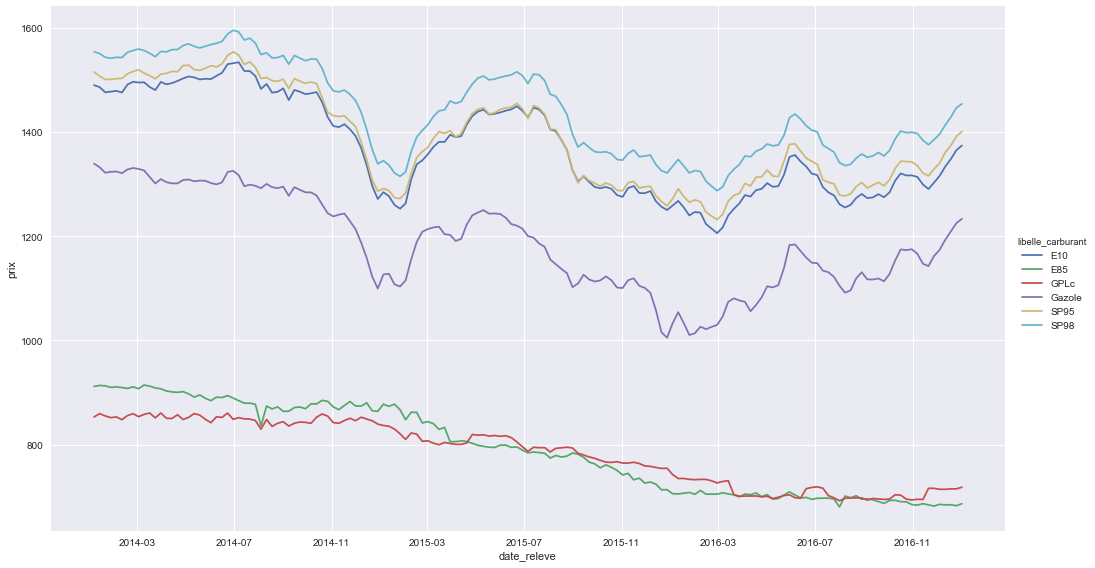

In [83]:
graph = sns.FacetGrid(moyenne_hebdo_df, hue='libelle_carburant', size=8, aspect=16/9)
graph.map(plt.plot, "date_releve", "prix")
graph.add_legend()